In [3]:
import h5py
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm
import sys
from torchvision.transforms import Resize
from matplotlib import pyplot

In [4]:
BATCH_SIZE=1024
KLD_WEIGHT=1e-4
LR=0.001
epochs=3

In [8]:


class VAE(nn.Module):
    def __init__(self,input_dim:int=50*50*3,latent_dim:int=16):
        super(VAE,self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.encoder =  nn.Sequential(nn.Linear(input_dim,2048,device=self.device,dtype=torch.float64),
                                      nn.ReLU(),
                                      nn.Linear(2048,512,device=self.device,dtype=torch.float64),
                                      nn.ReLU(),
                                      nn.Linear(512,128,device=self.device,dtype=torch.float64),
                                      nn.ReLU())
        self.logvar = nn.Linear(128,latent_dim,device=self.device,dtype=torch.float64)
        self.mu = nn.Linear(128,latent_dim,device=self.device,dtype=torch.float64)
        self.decoder = nn.Sequential(nn.Linear(latent_dim,128,device=self.device,dtype=torch.float64),
                                      nn.ReLU(),
                                      nn.Linear(128,512,device=self.device,dtype=torch.float64),
                                      nn.ReLU(),
                                      nn.Linear(512,2048,device=self.device,dtype=torch.float64),
                                      nn.ReLU(),
                                      nn.Linear(2048,input_dim,device=self.device,dtype=torch.float64),
                                      nn.ReLU())
        self.latent_dim = latent_dim

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def encode(self, x):
        pre_final = self.encoder(x)
        mu = self.mu(pre_final)
        logvar = self.logvar(pre_final)
        z = self.reparameterise(mu, logvar)
        return z, mu, logvar  
    
    def decode(self, z):
        out = self.decoder(z)
        return out
    
    def forward(self, x):
        z, mu, logvar = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, mu, logvar
        

In [5]:
from torch.utils.data import Dataset

f =  h5py.File('quark-gluon_data-set_n139306.hdf5', 'r')
print(f.keys())
XJets = f['X_jets']
m0 = f['m0']
pt = f['pt']
y = f['y']
print(XJets)
print(m0)
print(pt)
print(y)

class HDF5DataSet(Dataset):
    
    def __init__(self, x):
        self.batch_size=BATCH_SIZE
        self.x = x

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        samplex = Resize((50,50))(torch.permute(torch.tensor(self.x[idx:BATCH_SIZE], dtype= torch.float64),(0,3,1,2))).reshape(-1,50*50*3)
        # samplex = torch.tensor(self.x[idx:BATCH_SIZE], dtype= torch.float64).reshape(-1,50*50*3)
        return (samplex-samplex.min())/(samplex.max()-samplex.min())*255
    

<KeysViewHDF5 ['X_jets', 'm0', 'pt', 'y']>
<HDF5 dataset "X_jets": shape (139306, 125, 125, 3), type "<f4">
<HDF5 dataset "m0": shape (139306,), type "<f4">
<HDF5 dataset "pt": shape (139306,), type "<f4">
<HDF5 dataset "y": shape (139306,), type "<f4">


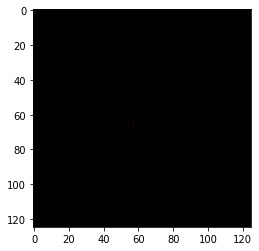

c:\Users\Aditya Choudhary\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


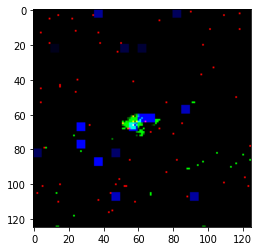

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


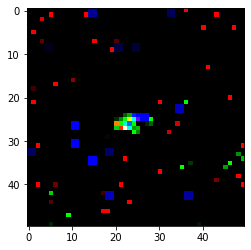

In [6]:
s = (torch.tensor(XJets[60000], dtype= torch.float64))
pyplot.imshow(s)
pyplot.show()
s=(s-s.min())/(s.max()-s.min())*255
# pyplot.imshow((torch.permute(s,(2,0,1))))
# pyplot.show()
x = torch.permute(Resize((50,50))(torch.permute(s,(2,0,1))).reshape(-1,50*50*3).reshape(3,50,50),(1,2,0))
from matplotlib import pyplot
pyplot.imshow(s)
pyplot.show()
pyplot.imshow(x)
pyplot.show()

In [7]:
def visual(im):
    import cv2
    import time
    im = XJets[15000]
    im = (im-im.min())/(im.max()-im.min())*255
    e,h,t=cv2.split(im)
    cv2.imshow('image',im)
    cv2.imshow('ecal',e)
    cv2.imshow('hcal',h)
    cv2.imshow('track',t)
    time.sleep(1)
    cv2.destroyAllWindows()

In [15]:
def vae_loss(true_data, reconstructed_data, mu, logvar, validate=False):
    mse = nn.MSELoss()
    mse_loss = mse(reconstructed_data, true_data)
    if not validate:
        kld_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return mse_loss + KLD_WEIGHT*kld_loss, mse_loss, KLD_WEIGHT*kld_loss
    else:
        return mse_loss
    
def fit(model, train_dl, train_ds, optimizer):
    print("### Beginning Training")

    model.train()

    running_loss = 0.0
    counter = 0
    # n_data = int(len(train_ds) / BATCH_SIZE)
    n_data=len(sampler)
    for inputs in tqdm(train_dl, total=n_data, desc="# Training"):
        counter += 1
        inputs = inputs.to(model.device)
        optimizer.zero_grad()
        reconstructions, mu, logvar = model(inputs)
        # print(mu)
        loss, mse_loss, kld_loss = vae_loss(inputs,reconstructions,mu,logvar)
        mse.append(mse_loss)
        kld.append(kld_loss)
        print('LOSS',loss.item(),mse_loss.item(),kld_loss.item())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / counter
    print(f"# Finished. Training Loss: {loss:.6f}")
    
    return epoch_loss, mse_loss, kld_loss    
    
def test(model, test_dl, test_ds):
    
    print("### Beginning Training")
    model.eval()
    running_loss = 0.0
    counter = 0
    n_data = len(test_sampler)
    
    with torch.no_grad():
        for inputs in tqdm(test_dl, total=n_data, desc="# Training"):
            counter += 1
            inputs = inputs.to(model.device)
            reconstructions, mu, logvar = model(inputs)
            # print(mu)
            loss, mse_loss, kld_loss = vae_loss(inputs,reconstructions,mu,logvar)
            print('TEST LOSS',loss.item(),mse_loss.item(),kld_loss.item())

            running_loss += loss.item()

        epoch_loss = running_loss / counter
        print(f"# Finished. Test Loss: {loss:.6f}")
        
        return epoch_loss, mse_loss, kld_loss    



In [16]:
# from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import time

# training_data,test_data = train_test_split(XJets,test_size=0.15)
train_ds = HDF5DataSet(XJets)
test_ds = HDF5DataSet(XJets)
sampler = [i for i in range(40)]
sampler.extend([i for i in range(60,90)])
# train_dl = DataLoader(train_ds, batch_size=None,sampler=range(int(len(train_ds)/BATCH_SIZE)))
train_dl = DataLoader(train_ds, batch_size=None,sampler=sampler)
test_sampler=range(90,100)
test_dl = DataLoader(test_ds, batch_size=None, sampler=test_sampler)
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_loss = []
mse=[]
kld=[]
val_loss = []
start = time.time()

for epoch in range(1,epochs+1):
    KLD_WEIGHT/=10**(epoch%3-1)
    # LR/=10**(epoch%3==0)
    print(f"Epoch {epoch} of {epochs} with LR {LR} and KLD Weight {KLD_WEIGHT}")
    train_epoch_loss, mse_loss_fit, regularizer_loss_fit = fit(
        model=model,
        train_dl=train_dl,
        train_ds=train_ds,
        optimizer=optimizer
    )
    print('Epoch Loss',train_epoch_loss)
    train_loss.append(train_epoch_loss)
    torch.save(model.state_dict(),'./model1.pt')

end = time.time()

print(f"{(end - start) / 60:.3} minutes")

# data_as_tensor = torch.tensor(test_data.values, dtype=torch.float64)
# data_as_tensor = data_as_tensor.to(model.device)
# pred_as_tensor = model(data_as_tensor)



Epoch 1 of 3
### Beginning Training


# Training:   0%|          | 0/70 [00:00<?, ?it/s]

LOSS 0.2346588709031237 0.2346586230829991 2.478201246176407e-07


# Training:   1%|▏         | 1/70 [00:06<07:42,  6.71s/it]

LOSS 0.23274700986104158 0.23274562535564006 1.384505401528321e-06


# Training:   3%|▎         | 2/70 [00:13<07:30,  6.62s/it]

LOSS 0.23108053998714517 0.23107853341560133 2.0065715438305097e-06


# Training:   4%|▍         | 3/70 [00:19<07:09,  6.41s/it]

LOSS 0.22913731259607337 0.22913261529276774 4.697303305624567e-06


# Training:   6%|▌         | 4/70 [00:25<06:53,  6.26s/it]

LOSS 0.22674325204358609 0.22672880146248028 1.4450581105789417e-05


# Training:   7%|▋         | 5/70 [00:31<06:52,  6.35s/it]

LOSS 0.22481906750938155 0.22477567852120328 4.338898817827438e-05


# Training:   9%|▊         | 6/70 [00:38<06:57,  6.52s/it]

LOSS 0.22127046994307903 0.22121822078336123 5.224915971780796e-05


# Training:  10%|█         | 7/70 [00:45<06:44,  6.41s/it]

LOSS 0.21840731722669637 0.21833913357572202 6.818365097436805e-05


# Training:  11%|█▏        | 8/70 [00:51<06:31,  6.31s/it]

LOSS 0.2158925315589446 0.2157768912187635 0.00011564034018111587


# Training:  13%|█▎        | 9/70 [00:57<06:20,  6.24s/it]

LOSS 0.2142643932477215 0.21409880337238918 0.00016558987533233751


# Training:  14%|█▍        | 10/70 [01:03<06:11,  6.19s/it]

LOSS 0.2129537349116334 0.21279785396207856 0.0001558809495548356


# Training:  16%|█▌        | 11/70 [01:09<06:01,  6.13s/it]

LOSS 0.21160677350656823 0.21140900617856379 0.00019776732800445767


# Training:  17%|█▋        | 12/70 [01:15<05:53,  6.09s/it]

LOSS 0.2106418045632612 0.21037547568386755 0.0002663288793936513


# Training:  19%|█▊        | 13/70 [01:21<05:45,  6.05s/it]

LOSS 0.20898132272677505 0.2087275663493402 0.000253756377434866


# Training:  20%|██        | 14/70 [01:27<05:42,  6.11s/it]

LOSS 0.2075435960010931 0.20725980987947162 0.00028378612162146774


# Training:  21%|██▏       | 15/70 [01:33<05:34,  6.08s/it]

LOSS 0.206875259830141 0.2065538695442647 0.0003213902858763021


# Training:  23%|██▎       | 16/70 [01:39<05:26,  6.05s/it]

LOSS 0.20468796322768051 0.20433480120577333 0.0003531620219071748


# Training:  24%|██▍       | 17/70 [01:45<05:18,  6.01s/it]

LOSS 0.2024548634650626 0.20208350097812078 0.00037136248694183535


# Training:  26%|██▌       | 18/70 [01:51<05:11,  6.00s/it]

LOSS 0.19982613053702813 0.19941664101379897 0.0004094895232291724


# Training:  27%|██▋       | 19/70 [01:57<05:07,  6.04s/it]

LOSS 0.19673148885341868 0.19622302047655057 0.0005084683768680918


# Training:  29%|██▊       | 20/70 [02:03<05:00,  6.01s/it]

LOSS 0.19426207238333218 0.1936250653518125 0.00063700703151966


# Training:  30%|███       | 21/70 [02:09<04:53,  5.98s/it]

LOSS 0.19211193353822145 0.19142333354385735 0.0006885999943641081


# Training:  31%|███▏      | 22/70 [02:15<04:47,  6.00s/it]

LOSS 0.19012808375476595 0.18943789132717678 0.0006901924275891696


# Training:  33%|███▎      | 23/70 [02:21<04:42,  6.00s/it]

LOSS 0.18909391819061255 0.1883996485502134 0.0006942696403991541


# Training:  34%|███▍      | 24/70 [02:27<04:36,  6.00s/it]

LOSS 0.18807337980867445 0.18739790247396695 0.0006754773347074939


# Training:  36%|███▌      | 25/70 [02:33<04:29,  6.00s/it]

LOSS 0.18737783149500287 0.1867037829549534 0.0006740485400494487


# Training:  37%|███▋      | 26/70 [02:39<04:27,  6.07s/it]

LOSS 0.1862329459053816 0.18554930788096036 0.0006836380244212557


# Training:  39%|███▊      | 27/70 [02:45<04:23,  6.12s/it]

LOSS 0.18457646878701978 0.18393581552483892 0.0006406532621808548


# Training:  40%|████      | 28/70 [02:51<04:15,  6.09s/it]

LOSS 0.18306134163993545 0.18244280914591962 0.000618532494015843


# Training:  41%|████▏     | 29/70 [02:57<04:08,  6.06s/it]

LOSS 0.18111717151085321 0.18053391552037615 0.000583255990477061


# Training:  43%|████▎     | 30/70 [03:03<04:02,  6.06s/it]

LOSS 0.17929009350793604 0.1786708129860841 0.0006192805218519563


# Training:  44%|████▍     | 31/70 [03:09<03:55,  6.04s/it]

LOSS 0.1776468739262607 0.17700307817165825 0.0006437957546024318


# Training:  46%|████▌     | 32/70 [03:15<03:49,  6.03s/it]

LOSS 0.17489830026676342 0.17427830515609655 0.0006199951106668833


# Training:  47%|████▋     | 33/70 [03:21<03:42,  6.02s/it]

LOSS 0.17247999336659814 0.1718298222396042 0.0006501711269939497


# Training:  49%|████▊     | 34/70 [03:28<03:39,  6.10s/it]

LOSS 0.16951009207976764 0.1687981578582571 0.0007119342215105428


# Training:  50%|█████     | 35/70 [03:34<03:33,  6.11s/it]

LOSS 0.16726556963482112 0.1664500818344327 0.0008154878003884374


# Training:  51%|█████▏    | 36/70 [03:40<03:31,  6.23s/it]

LOSS 0.16521801197105823 0.16430423770378416 0.0009137742672740724


# Training:  53%|█████▎    | 37/70 [03:46<03:22,  6.14s/it]

LOSS 0.16231204064344087 0.1614119595330007 0.0009000811104401707


# Training:  54%|█████▍    | 38/70 [03:54<03:26,  6.46s/it]

LOSS 0.160128276980549 0.15915919115330227 0.0009690858272467159


# Training:  56%|█████▌    | 39/70 [04:00<03:21,  6.48s/it]

LOSS 0.15737469414351127 0.15640951248567533 0.0009651816578359308


# Training:  57%|█████▋    | 40/70 [04:06<03:10,  6.34s/it]

LOSS 0.17203501745648622 0.1710244101794478 0.0010106072770384163


# Training:  59%|█████▊    | 41/70 [04:12<02:59,  6.20s/it]

LOSS 0.17002447121515893 0.16888498892424292 0.0011394822909160114


# Training:  60%|██████    | 42/70 [04:18<02:51,  6.11s/it]

LOSS 0.16835710438686957 0.1671558792235261 0.0012012251633434785


# Training:  61%|██████▏   | 43/70 [04:24<02:42,  6.04s/it]

LOSS 0.16666068599875378 0.16544538733096545 0.0012152986677883284


# Training:  63%|██████▎   | 44/70 [04:30<02:35,  5.98s/it]

LOSS 0.16504732478070716 0.16383834546334866 0.0012089793173585114


# Training:  64%|██████▍   | 45/70 [04:35<02:27,  5.91s/it]

LOSS 0.16360730366005843 0.16240411116296244 0.0012031924970959842


# Training:  66%|██████▌   | 46/70 [04:41<02:21,  5.89s/it]

LOSS 0.162318842112461 0.16104830097754544 0.001270541134915557


# Training:  67%|██████▋   | 47/70 [04:47<02:14,  5.85s/it]

LOSS 0.16126253489012493 0.1599188525107247 0.0013436823794002203


# Training:  69%|██████▊   | 48/70 [04:53<02:08,  5.83s/it]

LOSS 0.16010016241768277 0.15875594643098276 0.0013442159867000107


# Training:  70%|███████   | 49/70 [04:58<02:01,  5.80s/it]

LOSS 0.15925272716757952 0.15791118994372177 0.0013415372238577323


# Training:  71%|███████▏  | 50/70 [05:04<01:55,  5.80s/it]

LOSS 0.1582490220799685 0.15690305333107463 0.0013459687488938574


# Training:  73%|███████▎  | 51/70 [05:10<01:50,  5.80s/it]

LOSS 0.15716881944184127 0.1557711108122153 0.0013977086296259667


# Training:  74%|███████▍  | 52/70 [05:17<01:51,  6.19s/it]

LOSS 0.1558205930976198 0.15441317654879685 0.0014074165488229433


# Training:  76%|███████▌  | 53/70 [05:26<01:58,  6.98s/it]

LOSS 0.15495345855947767 0.1535753992052864 0.0013780593541912838


# Training:  77%|███████▋  | 54/70 [05:32<01:46,  6.68s/it]

LOSS 0.15411425343737759 0.15274324116784857 0.0013710122695290185


# Training:  79%|███████▊  | 55/70 [05:39<01:40,  6.69s/it]

LOSS 0.15308914492226558 0.1517161958097919 0.001372949112473692


# Training:  80%|████████  | 56/70 [05:45<01:31,  6.55s/it]

LOSS 0.15168387798477592 0.15026234748763623 0.0014215304971396995


# Training:  81%|████████▏ | 57/70 [05:52<01:26,  6.64s/it]

LOSS 0.15076717215271807 0.14929091206274506 0.0014762600899730074


# Training:  83%|████████▎ | 58/70 [05:59<01:21,  6.78s/it]

LOSS 0.14959100235784797 0.14809272718941996 0.0014982751684280077


# Training:  84%|████████▍ | 59/70 [06:05<01:13,  6.71s/it]

LOSS 0.14827341250795148 0.1467450068722516 0.0015284056356998895


# Training:  86%|████████▌ | 60/70 [06:12<01:07,  6.78s/it]

LOSS 0.14654904110806619 0.14496866569454178 0.001580375413524405


# Training:  87%|████████▋ | 61/70 [06:21<01:05,  7.26s/it]

LOSS 0.14475651094260947 0.1430739375413296 0.001682573401279871


# Training:  89%|████████▊ | 62/70 [06:30<01:02,  7.76s/it]

LOSS 0.14306118961865358 0.14126992317718542 0.0017912664414681488


# Training:  90%|█████████ | 63/70 [06:36<00:51,  7.37s/it]

LOSS 0.14137699960966335 0.13948482780730226 0.0018921718023610856


# Training:  91%|█████████▏| 64/70 [06:43<00:44,  7.35s/it]

LOSS 0.14007878403879515 0.13805825369000083 0.002020530348794327


# Training:  93%|█████████▎| 65/70 [06:51<00:37,  7.58s/it]

LOSS 0.1396262839950053 0.137468986252525 0.0021572977424802902


# Training:  94%|█████████▍| 66/70 [06:58<00:29,  7.38s/it]

LOSS 0.13940791858226045 0.13716875746000903 0.0022391611222514324


# Training:  96%|█████████▌| 67/70 [07:04<00:20,  6.99s/it]

LOSS 0.13713501793585262 0.13480192807792135 0.002333089857931262


# Training:  97%|█████████▋| 68/70 [07:10<00:13,  6.67s/it]

LOSS 0.1352914701956585 0.132922207259563 0.0023692629360954846


# Training:  99%|█████████▊| 69/70 [07:16<00:06,  6.43s/it]

LOSS 0.13538426295009706 0.13291754248889387 0.0024667204612031863


# Training: 100%|██████████| 70/70 [07:22<00:00,  6.32s/it]


# Finished. Training Loss: 0.135384
Epoch Loss 0.1779789600805479
Epoch 2 of 3
### Beginning Training


# Training:   0%|          | 0/70 [00:00<?, ?it/s]

LOSS 0.11445805286064278 0.11422421662719137 0.00023383623345141753


# Training:   1%|▏         | 1/70 [00:06<07:25,  6.45s/it]

LOSS 0.11381315618751606 0.11357905422598968 0.00023410196152636736


# Training:   3%|▎         | 2/70 [00:12<07:18,  6.44s/it]

LOSS 0.11260308815230302 0.11236721689438245 0.0002358712579205737


# Training:   4%|▍         | 3/70 [00:19<07:16,  6.52s/it]

LOSS 0.11171814764741739 0.1114749935471798 0.00024315410023758766


# Training:   6%|▌         | 4/70 [00:25<07:02,  6.40s/it]

LOSS 0.11035317174297449 0.11010516262139483 0.00024800912157966023


# Training:   7%|▋         | 5/70 [00:31<06:50,  6.31s/it]

LOSS 0.10926750652398128 0.1090161871104368 0.00025131941354446973


# Training:   9%|▊         | 6/70 [00:38<06:53,  6.46s/it]

LOSS 0.1083742578522585 0.1081139175483946 0.0002603403038638979


# Training:  10%|█         | 7/70 [00:46<07:14,  6.90s/it]

LOSS 0.10725961115440058 0.10698559467828671 0.0002740164761138666


# Training:  11%|█▏        | 8/70 [00:53<07:15,  7.03s/it]

LOSS 0.10656834291825283 0.10628346641087749 0.00028487650737534594


# Training:  13%|█▎        | 9/70 [01:00<07:12,  7.09s/it]

LOSS 0.10560853858077604 0.10531747110493044 0.00029106747584561107


# Training:  14%|█▍        | 10/70 [01:07<06:56,  6.95s/it]

LOSS 0.10481901248325798 0.10451678835709759 0.000302224126160397


# Training:  16%|█▌        | 11/70 [01:14<06:46,  6.89s/it]

LOSS 0.10383050001597098 0.1035142292945117 0.00031627072145928


# Training:  17%|█▋        | 12/70 [01:21<06:36,  6.83s/it]

LOSS 0.10269181545050676 0.10236298286618263 0.00032883258432412824


# Training:  19%|█▊        | 13/70 [01:27<06:17,  6.62s/it]

LOSS 0.10175951028449064 0.10141924504377652 0.0003402652407141161


# Training:  20%|██        | 14/70 [01:33<06:12,  6.66s/it]

LOSS 0.10047276271811678 0.10011464223219993 0.0003581204859168502


# Training:  21%|██▏       | 15/70 [01:40<06:00,  6.56s/it]

LOSS 0.09944305302848058 0.09907295995993647 0.0003700930685441122


# Training:  23%|██▎       | 16/70 [01:46<05:55,  6.58s/it]

LOSS 0.09844636634707003 0.09805828800864262 0.0003880783384274156


# Training:  24%|██▍       | 17/70 [01:53<05:48,  6.57s/it]

LOSS 0.09767946256679386 0.09727297462604259 0.00040648794075126847


# Training:  26%|██▌       | 18/70 [02:00<05:43,  6.60s/it]

LOSS 0.0973325566584015 0.09690900810362726 0.00042354855477424037


# Training:  27%|██▋       | 19/70 [02:06<05:40,  6.67s/it]

LOSS 0.09704332926626444 0.09660012135755967 0.00044320790870475856


# Training:  29%|██▊       | 20/70 [02:13<05:30,  6.61s/it]

LOSS 0.09652113061501354 0.09606309814065621 0.0004580324743573342


# Training:  30%|███       | 21/70 [02:19<05:22,  6.59s/it]

LOSS 0.09591568242024823 0.09544426920144576 0.0004714132188024688


# Training:  31%|███▏      | 22/70 [02:26<05:12,  6.50s/it]

LOSS 0.0950664081681858 0.09457676277986828 0.0004896453883175251


# Training:  33%|███▎      | 23/70 [02:32<05:07,  6.54s/it]

LOSS 0.09474765063204799 0.09425585539610366 0.0004917952359443214


# Training:  34%|███▍      | 24/70 [02:39<05:05,  6.65s/it]

LOSS 0.09445128181637508 0.09394161353671622 0.0005096682796588625


# Training:  36%|███▌      | 25/70 [02:46<05:00,  6.67s/it]

LOSS 0.09446048897799125 0.0939449037878145 0.0005155851901767458


# Training:  37%|███▋      | 26/70 [02:53<04:52,  6.64s/it]

LOSS 0.0937366362806593 0.09321250646072465 0.0005241298199346429


# Training:  39%|███▊      | 27/70 [02:59<04:49,  6.72s/it]

LOSS 0.09285095043972917 0.09232136383469713 0.0005295866050320347


# Training:  40%|████      | 28/70 [03:06<04:36,  6.59s/it]

LOSS 0.09236916730157624 0.09183705077885061 0.0005321165227256228


# Training:  41%|████▏     | 29/70 [03:12<04:27,  6.53s/it]

LOSS 0.0923681884800973 0.0918260014041068 0.0005421870759905039


# Training:  43%|████▎     | 30/70 [03:19<04:20,  6.52s/it]

LOSS 0.09163189292830289 0.09109366418236269 0.0005382287459401942


# Training:  44%|████▍     | 31/70 [03:25<04:13,  6.51s/it]

LOSS 0.09096914347819926 0.09042372114556876 0.0005454223326304943


# Training:  46%|████▌     | 32/70 [03:32<04:09,  6.56s/it]

LOSS 0.09042541219091411 0.08987776090059069 0.0005476512903234306


# Training:  47%|████▋     | 33/70 [03:38<04:02,  6.55s/it]

LOSS 0.08988778585414658 0.08933426751157512 0.0005535183425714545


# Training:  49%|████▊     | 34/70 [03:45<03:55,  6.53s/it]

LOSS 0.08944061112201751 0.08888059334665178 0.0005600177753657268


# Training:  50%|█████     | 35/70 [03:51<03:49,  6.57s/it]

LOSS 0.08922092155607353 0.08866554369300125 0.0005553778630722753


# Training:  51%|█████▏    | 36/70 [03:58<03:40,  6.48s/it]

LOSS 0.08867882694765625 0.08811862267611724 0.0005602042715390064


# Training:  53%|█████▎    | 37/70 [04:04<03:32,  6.43s/it]

LOSS 0.08780969194318981 0.08724350152190319 0.0005661904212866213


# Training:  54%|█████▍    | 38/70 [04:11<03:26,  6.45s/it]

LOSS 0.0874009167762956 0.08683130684134306 0.000569609934952546


# Training:  56%|█████▌    | 39/70 [04:17<03:19,  6.44s/it]

LOSS 0.08736934852604432 0.08679721997757996 0.0005721285484643639


# Training:  57%|█████▋    | 40/70 [04:23<03:13,  6.44s/it]

LOSS 0.09980665498723769 0.09918302850565171 0.0006236264815859836


# Training:  59%|█████▊    | 41/70 [04:29<03:03,  6.33s/it]

LOSS 0.09990582657465798 0.09927303797595408 0.0006327885987039018


# Training:  60%|██████    | 42/70 [04:36<02:54,  6.25s/it]

LOSS 0.10047633170630882 0.09985462477610667 0.0006217069302021487


# Training:  61%|██████▏   | 43/70 [04:42<02:47,  6.19s/it]

LOSS 0.10179947869673499 0.10116488031932504 0.0006345983774099553


# Training:  63%|██████▎   | 44/70 [04:48<02:38,  6.11s/it]

LOSS 0.10181566189046268 0.10120150465758236 0.0006141572328803197


# Training:  64%|██████▍   | 45/70 [04:54<02:32,  6.09s/it]

LOSS 0.10063165708113843 0.10000431619162471 0.0006273408895137196


# Training:  66%|██████▌   | 46/70 [05:00<02:30,  6.27s/it]

LOSS 0.09932563139714973 0.09871271600068487 0.000612915396464853


# Training:  67%|██████▋   | 47/70 [05:07<02:25,  6.32s/it]

LOSS 0.10035822304050111 0.09975417267890906 0.0006040503615920594


# Training:  69%|██████▊   | 48/70 [05:13<02:19,  6.36s/it]

LOSS 0.09995092812687578 0.09933791178383095 0.0006130163430448413


# Training:  70%|███████   | 49/70 [05:20<02:19,  6.62s/it]

LOSS 0.09928275528556561 0.09868332855505936 0.0005994267305062518


# Training:  71%|███████▏  | 50/70 [05:27<02:14,  6.73s/it]

LOSS 0.09982599741531462 0.099239240300041 0.0005867571152736172


# Training:  73%|███████▎  | 51/70 [05:34<02:04,  6.57s/it]

LOSS 0.09891897292044502 0.09832857401584638 0.0005903989045986397


# Training:  74%|███████▍  | 52/70 [05:40<01:56,  6.46s/it]

LOSS 0.09907610983864353 0.09849222514693252 0.0005838846917109971


# Training:  76%|███████▌  | 53/70 [05:46<01:47,  6.30s/it]

LOSS 0.09912499710238176 0.09855372229846053 0.0005712748039212339


# Training:  77%|███████▋  | 54/70 [05:52<01:41,  6.37s/it]

LOSS 0.09852713799445863 0.09795826570648883 0.0005688722879698056


# Training:  79%|███████▊  | 55/70 [05:59<01:36,  6.46s/it]

LOSS 0.09904705796794507 0.09847693362622433 0.0005701243417207438


# Training:  80%|████████  | 56/70 [06:06<01:32,  6.61s/it]

LOSS 0.09824423990379172 0.0976832476750557 0.0005609922287360167


# Training:  81%|████████▏ | 57/70 [06:12<01:25,  6.55s/it]

LOSS 0.09842721538985762 0.0978739069895578 0.0005533084002998248


# Training:  83%|████████▎ | 58/70 [06:19<01:19,  6.60s/it]

LOSS 0.09838124898994627 0.09782790470594101 0.0005533442840052596


# Training:  84%|████████▍ | 59/70 [06:26<01:13,  6.66s/it]

LOSS 0.09820095641408794 0.09765034932983793 0.0005506070842500033


# Training:  86%|████████▌ | 60/70 [06:34<01:09,  6.99s/it]

LOSS 0.09816878934974474 0.09762337395182843 0.0005454153979163039


# Training:  87%|████████▋ | 61/70 [06:41<01:04,  7.14s/it]

LOSS 0.09794838681384181 0.09740555272271678 0.0005428340911250295


# Training:  89%|████████▊ | 62/70 [06:48<00:56,  7.11s/it]

LOSS 0.09811690810363198 0.09757875448846978 0.0005381536151621919


# Training:  90%|█████████ | 63/70 [06:54<00:47,  6.83s/it]

LOSS 0.09806076536489873 0.09752828773163662 0.0005324776332621097


# Training:  91%|█████████▏| 64/70 [07:00<00:39,  6.61s/it]

LOSS 0.09794386862972597 0.0974110493323845 0.0005328192973414717


# Training:  93%|█████████▎| 65/70 [07:06<00:32,  6.46s/it]

LOSS 0.09800407559754708 0.09747086161452709 0.0005332139830199846


# Training:  94%|█████████▍| 66/70 [07:13<00:25,  6.35s/it]

LOSS 0.0979593724343534 0.09743248008008229 0.000526892354271109


# Training:  96%|█████████▌| 67/70 [07:19<00:18,  6.26s/it]

LOSS 0.09802109455381236 0.09749555698203298 0.0005255375717793739


# Training:  97%|█████████▋| 68/70 [07:25<00:12,  6.18s/it]

LOSS 0.09790400521384014 0.0973764805422031 0.000527524671637044


# Training:  99%|█████████▊| 69/70 [07:31<00:06,  6.11s/it]

LOSS 0.09783691544134776 0.0973141378095078 0.000522777631839963


# Training: 100%|██████████| 70/70 [07:36<00:00,  6.53s/it]


# Finished. Training Loss: 0.097837
Epoch Loss 0.09871365204458414
Epoch 3 of 3
### Beginning Training


# Training:   0%|          | 0/70 [00:00<?, ?it/s]

LOSS 0.09023987644753514 0.08569760276221337 0.004542273685321778


# Training:   1%|▏         | 1/70 [00:06<07:18,  6.36s/it]

LOSS 0.09002234150479162 0.08556368495933192 0.004458656545459696


# Training:   3%|▎         | 2/70 [00:12<07:07,  6.29s/it]

LOSS 0.08979997749349783 0.08544412853033005 0.004355848963167783


# Training:   4%|▍         | 3/70 [00:18<06:59,  6.27s/it]

LOSS 0.08959937040197509 0.08539042285352812 0.0042089475484469755


# Training:   6%|▌         | 4/70 [00:25<06:52,  6.25s/it]

LOSS 0.0891741280253435 0.08514370685749703 0.00403042116784646


# Training:   7%|▋         | 5/70 [00:31<06:46,  6.26s/it]

LOSS 0.08903279157861838 0.08518353543763772 0.003849256140980648


# Training:   9%|▊         | 6/70 [00:37<06:40,  6.26s/it]

LOSS 0.08886634408857959 0.0851953233771417 0.003671020711437896


# Training:  10%|█         | 7/70 [00:43<06:33,  6.25s/it]

LOSS 0.08876018230204026 0.08526100027453316 0.003499182027507098


# Training:  11%|█▏        | 8/70 [00:49<06:24,  6.20s/it]

LOSS 0.0885631235663805 0.08521912369367354 0.0033439998727069686


# Training:  13%|█▎        | 9/70 [00:56<06:18,  6.21s/it]

LOSS 0.088463433429409 0.08527553170757551 0.003187901721833493


# Training:  14%|█▍        | 10/70 [01:02<06:13,  6.22s/it]

LOSS 0.08835514704801471 0.08531949419545191 0.0030356528525627958


# Training:  16%|█▌        | 11/70 [01:08<06:06,  6.22s/it]

LOSS 0.0881076375397262 0.08520466782873222 0.0029029697109939708


# Training:  17%|█▋        | 12/70 [01:14<05:59,  6.20s/it]

LOSS 0.08797264441410728 0.08517853070648562 0.002794113707621658


# Training:  19%|█▊        | 13/70 [01:20<05:53,  6.19s/it]

LOSS 0.08762574556824244 0.08493599290087904 0.002689752667363403


# Training:  20%|██        | 14/70 [01:27<05:47,  6.21s/it]

LOSS 0.08733690514033311 0.0847474973980283 0.0025894077423048206


# Training:  21%|██▏       | 15/70 [01:34<06:04,  6.63s/it]

LOSS 0.0873027192810021 0.08481132801209416 0.002491391268907928


# Training:  23%|██▎       | 16/70 [01:42<06:11,  6.88s/it]

LOSS 0.08720845724848945 0.08479854815282019 0.0024099090956692716


# Training:  24%|██▍       | 17/70 [01:49<06:13,  7.05s/it]

LOSS 0.0871487847488256 0.08481658271060173 0.002332202038223877


# Training:  26%|██▌       | 18/70 [01:56<06:04,  7.01s/it]

LOSS 0.08710538687576863 0.0848358277800212 0.0022695590957474317


# Training:  27%|██▋       | 19/70 [02:03<05:59,  7.04s/it]

LOSS 0.08712207076587694 0.08491265174299126 0.0022094190228856767


# Training:  29%|██▊       | 20/70 [02:09<05:38,  6.78s/it]

LOSS 0.08708177396279637 0.08493650044586291 0.0021452735169334505


# Training:  30%|███       | 21/70 [02:16<05:25,  6.63s/it]

LOSS 0.08700372862170185 0.0849119172746817 0.0020918113470201416


# Training:  31%|███▏      | 22/70 [02:22<05:14,  6.56s/it]

LOSS 0.08685067888768162 0.08480701369425876 0.0020436651934228646


# Training:  33%|███▎      | 23/70 [02:29<05:19,  6.81s/it]

LOSS 0.08683262647022859 0.08482993766709879 0.0020026888031298073


# Training:  34%|███▍      | 24/70 [02:36<05:13,  6.82s/it]

LOSS 0.08658693485524055 0.08462302479212 0.0019639100631205523


# Training:  36%|███▌      | 25/70 [02:43<05:09,  6.88s/it]

LOSS 0.08658668766422652 0.0846671678652915 0.0019195197989350149


# Training:  37%|███▋      | 26/70 [02:50<05:03,  6.90s/it]

LOSS 0.08655107485039085 0.08467127943146043 0.001879795418930428


# Training:  39%|███▊      | 27/70 [02:57<04:53,  6.82s/it]

LOSS 0.08620342941180291 0.08435686586592994 0.0018465635458729634


# Training:  40%|████      | 28/70 [03:03<04:42,  6.72s/it]

LOSS 0.08610425350253711 0.08428916109433376 0.001815092408203356


# Training:  41%|████▏     | 29/70 [03:12<04:52,  7.14s/it]

LOSS 0.08610013669644244 0.08431348954236259 0.0017866471540798473


# Training:  43%|████▎     | 30/70 [03:19<04:50,  7.26s/it]

LOSS 0.08608420480019173 0.0843305972591503 0.0017536075410414288


# Training:  44%|████▍     | 31/70 [03:25<04:30,  6.95s/it]

LOSS 0.08610057803270364 0.08437749329590512 0.0017230847367985282


# Training:  46%|████▌     | 32/70 [03:32<04:23,  6.93s/it]

LOSS 0.08581593704748465 0.08411775049266598 0.0016981865548186723


# Training:  47%|████▋     | 33/70 [03:38<04:07,  6.69s/it]

LOSS 0.08584158361451691 0.08416882153339189 0.0016727620811250233


# Training:  49%|████▊     | 34/70 [03:45<03:55,  6.55s/it]

LOSS 0.08564008766373292 0.08398993875690175 0.00165014890683117


# Training:  50%|█████     | 35/70 [03:51<03:49,  6.54s/it]

LOSS 0.08560453696626734 0.08397898005727299 0.0016255569089943564


# Training:  51%|█████▏    | 36/70 [03:59<03:52,  6.84s/it]

LOSS 0.08560159930520804 0.08400081010770198 0.0016007891975060573


# Training:  53%|█████▎    | 37/70 [04:05<03:44,  6.80s/it]

LOSS 0.0850734658655171 0.08349546854665936 0.0015779973188577445


# Training:  54%|█████▍    | 38/70 [04:11<03:30,  6.59s/it]

LOSS 0.08507526894609693 0.08351524107313099 0.001560027872965942


# Training:  56%|█████▌    | 39/70 [04:18<03:20,  6.46s/it]

LOSS 0.08508510856744111 0.0835467049995736 0.0015384035678675046


# Training:  57%|█████▋    | 40/70 [04:24<03:11,  6.38s/it]

LOSS 0.09753187168391675 0.09587734829251654 0.0016545233914002093


# Training:  59%|█████▊    | 41/70 [04:30<03:01,  6.27s/it]

LOSS 0.09761381535260565 0.09598194955476505 0.0016318657978406006


# Training:  60%|██████    | 42/70 [04:36<02:54,  6.22s/it]

LOSS 0.09773809498665746 0.09612614422412621 0.001611950762531252


# Training:  61%|██████▏   | 43/70 [04:42<02:46,  6.18s/it]

LOSS 0.09835627856114636 0.09676244379139513 0.0015938347697512193


# Training:  63%|██████▎   | 44/70 [04:49<02:49,  6.53s/it]

LOSS 0.0997174568803073 0.09812501277746317 0.0015924441028441188


# Training:  64%|██████▍   | 45/70 [04:56<02:42,  6.52s/it]

LOSS 0.1012535138725853 0.09967482908165358 0.0015786847909317245


# Training:  66%|██████▌   | 46/70 [05:03<02:38,  6.60s/it]

LOSS 0.09975728312478005 0.09816060620114579 0.0015966769236342609


# Training:  67%|██████▋   | 47/70 [05:10<02:35,  6.77s/it]

LOSS 0.09956027947319501 0.09795880215009221 0.0016014773231028017


# Training:  69%|██████▊   | 48/70 [05:19<02:46,  7.57s/it]

LOSS 0.09978481218787558 0.09818205696261591 0.001602755225259669


# Training:  70%|███████   | 49/70 [05:29<02:52,  8.20s/it]

LOSS 0.09887654489106767 0.09727536844454848 0.0016011764465191875


# Training:  71%|███████▏  | 50/70 [05:36<02:38,  7.93s/it]

LOSS 0.09977988192795319 0.09818197872952787 0.0015979031984253165


# Training:  73%|███████▎  | 51/70 [05:43<02:24,  7.59s/it]

LOSS 0.09865441028231332 0.09707523806742349 0.0015791722148898344


# Training:  74%|███████▍  | 52/70 [05:50<02:15,  7.51s/it]

LOSS 0.09887747912084614 0.09733277607702935 0.0015447030438167902


# Training:  76%|███████▌  | 53/70 [05:57<02:02,  7.20s/it]

LOSS 0.09857185102534104 0.0970357599125272 0.0015360911128138378


# Training:  77%|███████▋  | 54/70 [06:03<01:51,  6.95s/it]

LOSS 0.09862656088092923 0.09708060924073328 0.0015459516401959603


# Training:  79%|███████▊  | 55/70 [06:09<01:41,  6.76s/it]

LOSS 0.09856360378725192 0.097037365285325 0.0015262385019269187


# Training:  80%|████████  | 56/70 [06:16<01:35,  6.79s/it]

LOSS 0.09811614379290809 0.09663316855243094 0.0014829752404771533


# Training:  81%|████████▏ | 57/70 [06:24<01:30,  6.99s/it]

LOSS 0.09827751138317743 0.0968185949135263 0.00145891646965113


# Training:  83%|████████▎ | 58/70 [06:30<01:21,  6.77s/it]

LOSS 0.0979839061480783 0.09653468153482342 0.0014492246132548825


# Training:  84%|████████▍ | 59/70 [06:36<01:12,  6.58s/it]

LOSS 0.0982896231355571 0.09684971203290373 0.0014399111026533705


# Training:  86%|████████▌ | 60/70 [06:43<01:06,  6.65s/it]

LOSS 0.09780265645689197 0.09637864300210344 0.0014240134547885324


# Training:  87%|████████▋ | 61/70 [06:50<01:00,  6.77s/it]

LOSS 0.09797442220000303 0.09657173944131972 0.0014026827586833086


# Training:  89%|████████▊ | 62/70 [06:57<00:54,  6.84s/it]

LOSS 0.09793701834894754 0.09655705600935238 0.0013799623395951582


# Training:  90%|█████████ | 63/70 [07:04<00:47,  6.81s/it]

LOSS 0.09792534094895461 0.09655651389722829 0.001368827051726327


# Training:  91%|█████████▏| 64/70 [07:10<00:39,  6.61s/it]

LOSS 0.09806507252922132 0.09670392239319837 0.0013611501360229522


# Training:  93%|█████████▎| 65/70 [07:16<00:32,  6.49s/it]

LOSS 0.09785376133533744 0.09651316929083595 0.0013405920445014887


# Training:  94%|█████████▍| 66/70 [07:22<00:25,  6.39s/it]

LOSS 0.09805881471232757 0.09673610940403864 0.0013227053082889293


# Training:  96%|█████████▌| 67/70 [07:28<00:18,  6.29s/it]

LOSS 0.09790111308399703 0.09658471341171836 0.0013163996722786698


# Training:  97%|█████████▋| 68/70 [07:35<00:12,  6.26s/it]

LOSS 0.09794092539793783 0.09663131199502605 0.0013096134029117923


# Training:  99%|█████████▊| 69/70 [07:41<00:06,  6.44s/it]

LOSS 0.09789832367110017 0.09660243129523864 0.0012958923758615351


# Training: 100%|██████████| 70/70 [07:48<00:00,  6.70s/it]


# Finished. Training Loss: 0.097898
Epoch Loss 0.09207027334834253
22.8 minutes


In [17]:
# print(model.state_dict())
torch.save(model.state_dict(),'./model1.pt')

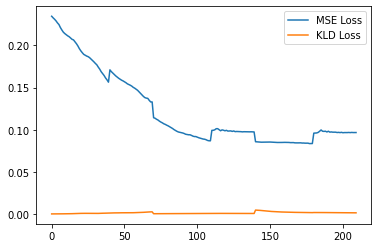

In [18]:
from matplotlib import pyplot

pyplot.plot([i.detach() for i in mse],label='MSE Loss')
pyplot.plot([i.detach() for i in kld],label='KLD Loss')
pyplot.legend()
pyplot.show()

In [19]:
test(model,test_dl,test_ds)

### Beginning Training


# Training:  10%|█         | 1/10 [00:04<00:39,  4.44s/it]

TEST LOSS 0.09780900136292947 0.09652979064125113 0.0012792107216783423


# Training:  20%|██        | 2/10 [00:08<00:32,  4.03s/it]

TEST LOSS 0.0978522101929162 0.09657204012332136 0.0012801700695948444


# Training:  30%|███       | 3/10 [00:11<00:27,  3.87s/it]

TEST LOSS 0.09784240302205814 0.0965609969835596 0.0012814060384985313


# Training:  40%|████      | 4/10 [00:15<00:22,  3.81s/it]

TEST LOSS 0.09767529659330983 0.09639274958591118 0.00128254700739864


# Training:  50%|█████     | 5/10 [00:19<00:19,  3.83s/it]

TEST LOSS 0.09772553774986148 0.09644249480193477 0.0012830429479267131


# Training:  60%|██████    | 6/10 [00:23<00:15,  3.90s/it]

TEST LOSS 0.09781896532767824 0.09653483510302818 0.001284130224650055


# Training:  70%|███████   | 7/10 [00:27<00:11,  3.89s/it]

TEST LOSS 0.09731132396704628 0.09602598976200928 0.0012853342050370019


# Training:  80%|████████  | 8/10 [00:31<00:07,  3.90s/it]

TEST LOSS 0.09740468891634174 0.09612040262463901 0.0012842862917027216


# Training:  90%|█████████ | 9/10 [00:35<00:03,  3.92s/it]

TEST LOSS 0.09739287224363538 0.09610740759229165 0.0012854646513437262


# Training: 100%|██████████| 10/10 [00:40<00:00,  4.01s/it]

TEST LOSS 0.09744218234219285 0.0961627757506057 0.0012794065915871574
# Finished. Test Loss: 0.097442


(0.09762744817179696,
 tensor(0.0962, dtype=torch.float64),
 tensor(0.0013, dtype=torch.float64))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


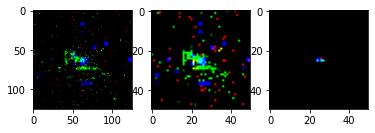

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


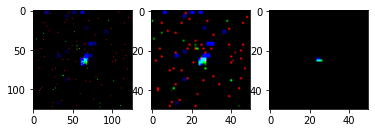

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


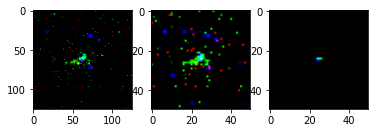

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


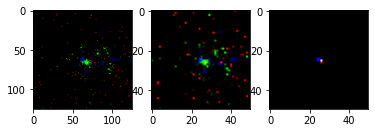

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


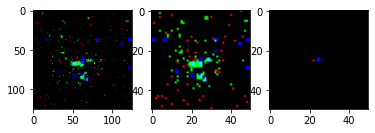

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


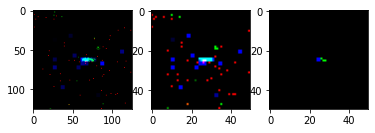

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


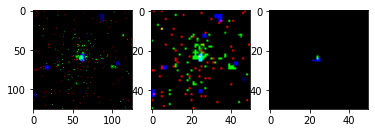

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


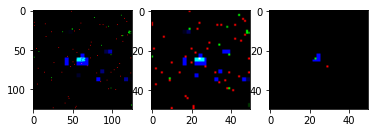

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


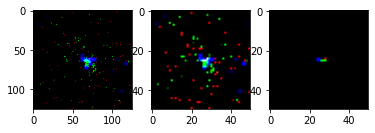

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


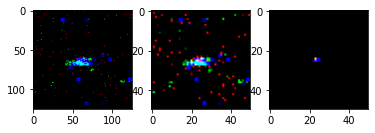

In [11]:
import cv2
import torch
from matplotlib import pyplot
from torchvision.transforms import Resize
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
model=VAE()
model.load_state_dict(torch.load('./model1.pt'))
f1 = open('reco.txt','w+')
f2 = open('og.txt','w+')
for i in range(10):
    original = Resize((50,50))(torch.permute(torch.tensor(XJets[i*2000+00000], dtype= torch.float64),(2,0,1))).reshape(-1,50*50*3)

    # original = Resize(50)(torch.tensor(XJets[i*2000+60000], dtype= torch.float64).reshape(3,50,50)).reshape(50*50*3)
    og = torch.tensor(XJets[i*2000+00000], dtype= torch.float64)
    og = (og-og.min())/(og.max()-og.min())*255
    original = (original-original.min())/(original.max()-original.min())*255
    reconstructed = torch.permute(model(original)[0].reshape(3,50,50),(1,2,0))
    reconstructed = (reconstructed-reconstructed.min())/(reconstructed.max()-reconstructed.min())*255
    original = torch.permute(original.reshape(3,50,50),(1,2,0)).detach()
    original = original.detach().numpy()
    reconstructed = reconstructed.detach().numpy()
    fig,axs = pyplot.subplots(1,3)
    f1.write(np.array2string(reconstructed))
    f2.write(np.array2string(original))
    # print(original)
    # print(reconstructed)
    axs[0].imshow(og)
    axs[1].imshow(original)
    axs[2].imshow(reconstructed)
    pyplot.show()